attn_weight torch.Size([197, 197])


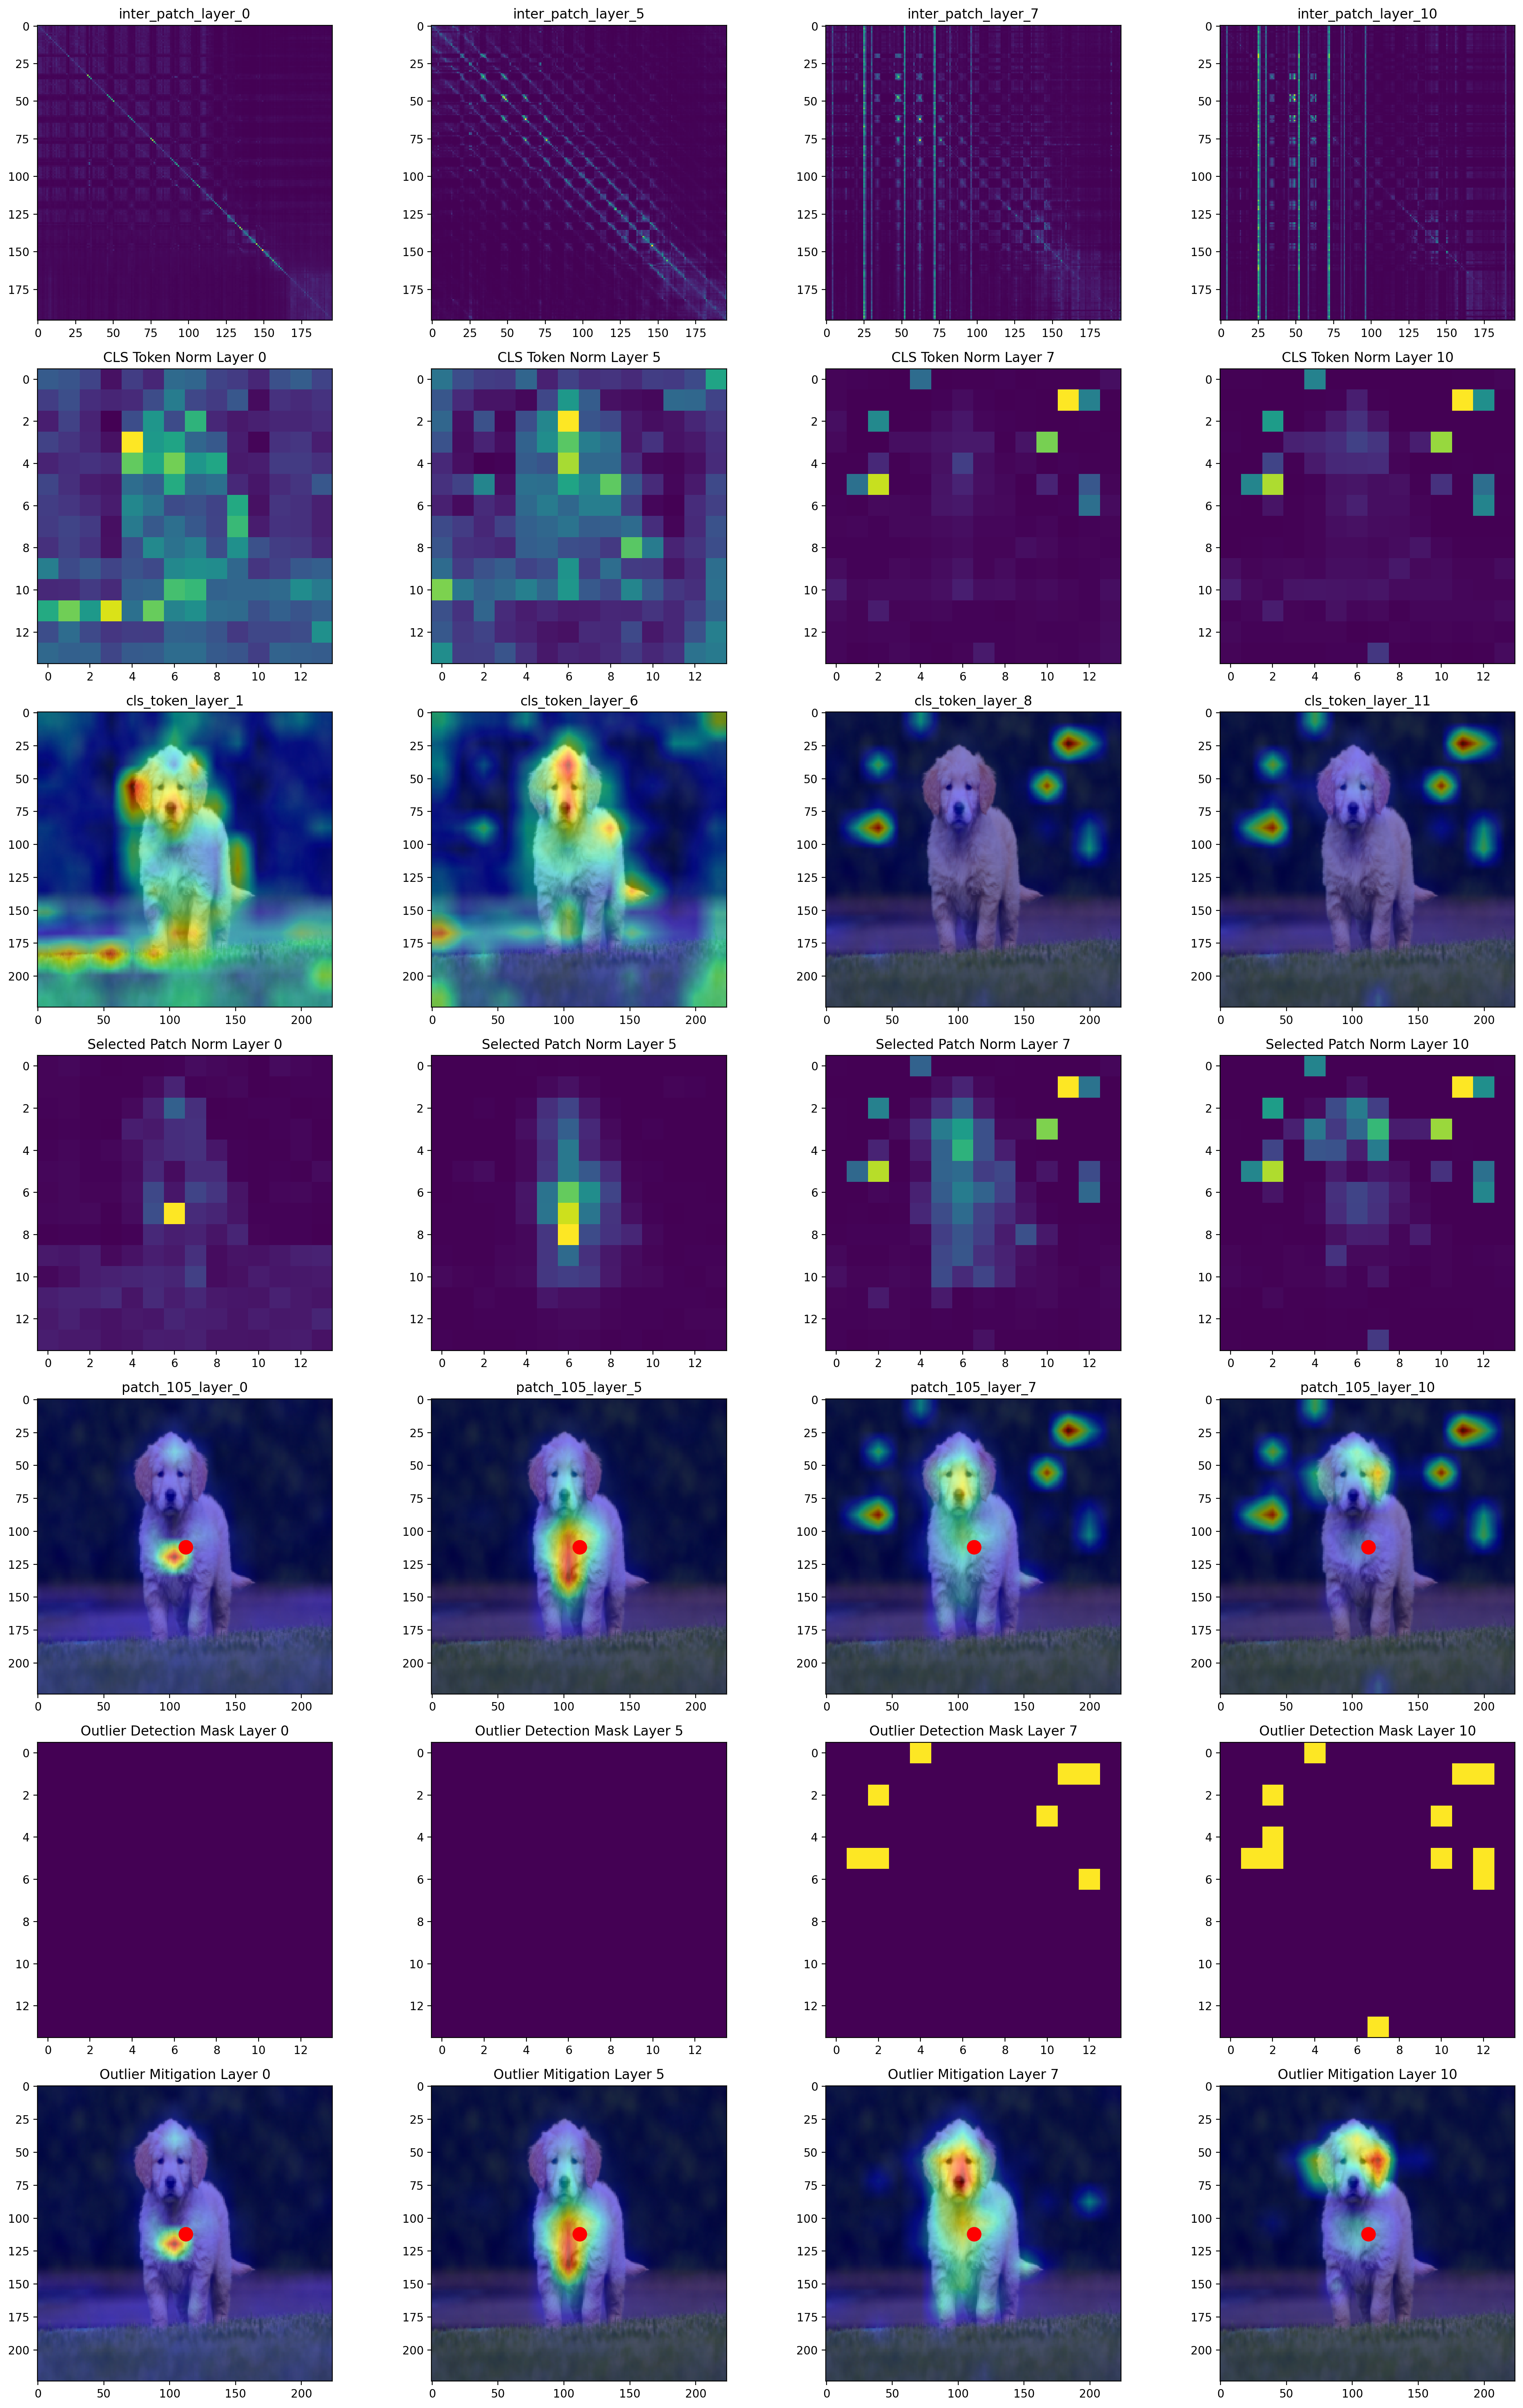

In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from SFP_segmentor import SFPForSegmentation
import numpy as np

img = Image.open('demo/dog.jpg')
ori_h, ori_w = img.size[1], img.size[0]
img_tensor = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711]),
])(img)
img_tensor = img_tensor.unsqueeze(0).cuda()

model = SFPForSegmentation(
    clip_path='ViT-B/16',
    name_path='./demo/test.txt',
    pamr_steps=0,
    pamr_stride=(8, 16),
    slide_crop=0,
    slide_stride=112
)


def get_visual_features(clip, images):
    visual_features, attn_weights = clip.encode_image_vis(images, return_each=True, return_attn=True)
    return visual_features, attn_weights

patch_window = 16
h, w = img_tensor.shape[-2]//patch_window, img_tensor.shape[-1]//patch_window
visual_features, attn_weights = get_visual_features(model.net, img_tensor)

center_h, center_w = h // 2, w // 2
center_idx = center_h * w + center_w


layer_idxs = [0,5,7,10]
layers = len(layer_idxs)
attn_weights = attn_weights[layer_idxs,0]
# attn_weights multihead to single
attn_weights = attn_weights.mean(dim=1)
# attn_weights = attn_weights.sum(dim=1)

img_vis = transforms.Resize((224, 224))(img)

fig = plt.figure(figsize=(20, 30), dpi=200)

# visual features
visual_features = visual_features.squeeze()  # Remove batch dimension

vmin, vmax = 0, 1  

for i in range(layers):
    # 1. inter-patch weig
    plt.subplot(7,layers,i+1)
    plt.imshow(attn_weights[i,1:,1:].detach().cpu().numpy())
    plt.title('inter_patch_layer_'+str(layer_idxs[i]))

    # 2. cls token norm visualization 
    plt.subplot(7,layers,i+1*layers+1)
    cls_token = attn_weights[i,0,1:]
    cls_token = cls_token.reshape(h,w)
    plt.imshow(cls_token.detach().cpu().numpy(), cmap='viridis')
    plt.title(f'CLS Token Norm Layer {layer_idxs[i]}')
    
    # 3. cls token overlay
    plt.subplot(7,layers,i+2*layers+1)
    cls_token = attn_weights[i,0,1:]
    cls_token = cls_token.reshape(h,w)
    cls_token = F.interpolate(cls_token.unsqueeze(0).unsqueeze(0), 
                            size=(224, 224), mode='bilinear',
                            align_corners=False)[0,0]
    plt.imshow(img_vis)
    plt.imshow(cls_token.detach().cpu().numpy(),alpha=0.5,cmap='jet')
    plt.title('cls_token_layer_'+str(layer_idxs[i]+1))

    # 4. selected patch norm 
    plt.subplot(7,layers,i+3*layers+1)
    patch_token = attn_weights[i, center_idx, 1:]
    patch_token = patch_token.reshape(h,w)
    plt.imshow(patch_token.detach().cpu().numpy(), cmap='viridis')
    plt.title(f'Selected Patch Norm Layer {layer_idxs[i]}')

    # 5. selected patch overlay 
    plt.subplot(7,layers,i+4*layers+1)
    patch_token = attn_weights[i, center_idx, 1:]
    patch_token = patch_token.reshape(h,w)
    patch_token = F.interpolate(patch_token.unsqueeze(0).unsqueeze(0), 
                              size=(224, 224), mode='bilinear',
                              align_corners=False)[0,0]
    plt.imshow(img_vis)
    plt.imshow(patch_token.detach().cpu().numpy(),alpha=0.5,cmap='jet')
    row = center_h * patch_window
    col = center_w * patch_window
    plt.plot(col, row, 
         marker='o',          
         color='red',        
         markerfacecolor='red', 
         markersize=12)      
    plt.title('patch_'+str(center_idx)+'_layer_'+str(layer_idxs[i]))

    # 6. Outlier detection mask visualization
    plt.subplot(7,layers,i+5*layers+1)
    # ~mask or 1 - mask
    self_attn = torch.diag(attn_weights[i,1:,1:])  
    cls_token = attn_weights[i,0,1:]  
    mask = torch.le(cls_token, self_attn)  # less than or equal
    mask_vis = (~mask).float().reshape(h,w) 
    im = plt.imshow(mask_vis.detach().cpu().numpy(), 
                   cmap='viridis',
                   vmin=vmin,      
                   vmax=vmax)
    plt.title(f'Outlier Detection Mask Layer {layer_idxs[i]}')  
    
    # 7. based on selected patch overlay, to make outlier patch to zero
    plt.subplot(7,layers,i+6*layers+1)
    patch_token = attn_weights[i, center_idx, 1:]
    patch_token = patch_token * mask.float()  # apply mask
    patch_token = patch_token.reshape(h,w)
    patch_token = F.interpolate(patch_token.unsqueeze(0).unsqueeze(0), 
                              size=(224, 224), mode='bilinear',
                              align_corners=False)[0,0]
    plt.imshow(img_vis)
    plt.imshow(patch_token.detach().cpu().numpy(),alpha=0.5,cmap='jet')
    plt.plot(col, row, 
         marker='o',        
         color='red',         
         markerfacecolor='red', 
         markersize=12)      
    plt.title(f'Outlier Mitigation Layer {layer_idxs[i]}')  
    

plt.tight_layout()